# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1a9105cb6fbd58d78f354c37a523fe85fee46452ed22c2a78a93fc37aef10693
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
%cd /content/drive/MyDrive/DS200/Project

/content/drive/MyDrive/DS200/Project


In [4]:
!ls

'anomalydetection_2 (1).ipynb'	 DL_Model_2	    lib		      Model.ipynb
 config				 DL_Model_3.h5	    LoadModel.ipynb   Pipe
 creditcard.csv			 DL_Model_3.keras   LoadPipe.ipynb    SMOTE_Li_BestModel_RandomFR
 DL_Model			 DL_Model.h5	    logs


In [5]:
!pip install findspark

In [6]:
import os
import random
import pandas as pd
pd.options.display.max_columns=None
pd.options.display.max_rows=None

#import toolkits
from lib import util
from lib import logger

def initialize_spark(app_name='spark_pipeline'):
    import findspark
    #spark path using default value
    findspark.init()

    import pyspark
    # import pyarrow
    from pyspark.sql import SQLContext

    #broadcastTimeout is purposedly set to be large due to development on single machine
    conf = pyspark.SparkConf()\
        .setAppName(app_name)\
        .setMaster('local')\
        .set('spark.driver.memory', '16g')\
        .set('spark.executor.memory', '16g')\
        .set('spark.executor.instances', 4)\
        .set('spark.executor.cores', 4)\
        .set('spark.driver.maxResultSize', '8g')\
        .set('spark.sql.shuffle.partitions', 100)\
        .set('spark.default.parallelism', 200)\
        .set('spark.sql.broadcastTimeout', 36000)\
        .set('spark.kryoserializer.buffer.max', '1024m')\
        .set('spark.sql.execution.arrow.enabled', 'false')\
        .set('spark.dynamicAllocation.enabled', "False")\
        .set('spark.port.maxRetries',30)

    sc = pyspark.SparkContext.getOrCreate(conf)
    spark = pyspark.sql.SparkSession(sc)
    sqlContext = SQLContext.getOrCreate(sc)
    return sc,spark,sqlContext

from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.types import IntegerType,DecimalType
from pyspark.sql.functions import when, lit
from distutils.version import LooseVersion
from importlib import reload
import pyspark.sql.functions as func
import pyspark.sql.types as typ

from config.conf_template import Struct as Section
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import lib.imbalance_handler as imbalance_handle
import lib.feature_selection as fs
import lib.categorical_handler as ctgy
import lib.modelling as model

from pyspark.ml import Pipeline
reload(ctgy)
reload(fs)
reload(imbalance_handle)
reload(model)

<module 'lib.modelling' from '/content/drive/MyDrive/DS200/Project/lib/modelling.py'>

In [7]:
import numpy as np # linear algebra
import pyspark
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import math

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString

In [8]:
sc,spark,sqlContext = initialize_spark()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [9]:
# sparkContext=spark.sparkContext

# Model

In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

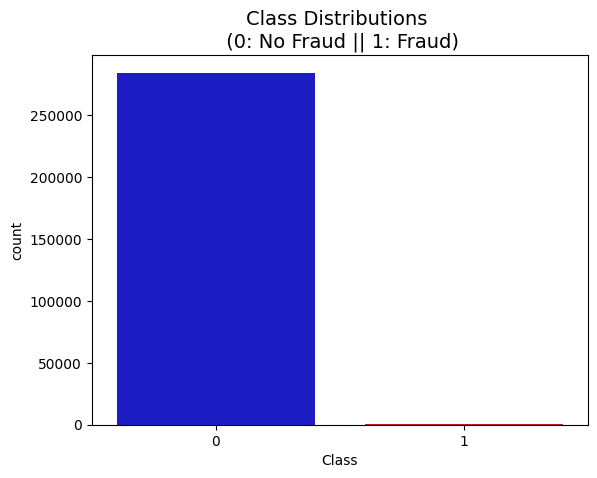

In [ ]:
colors = ["#0101DF", "#DF0101"]
sns.countplot(df, x = 'Class', palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [ ]:
t = list(df.columns)
t.remove('Class')

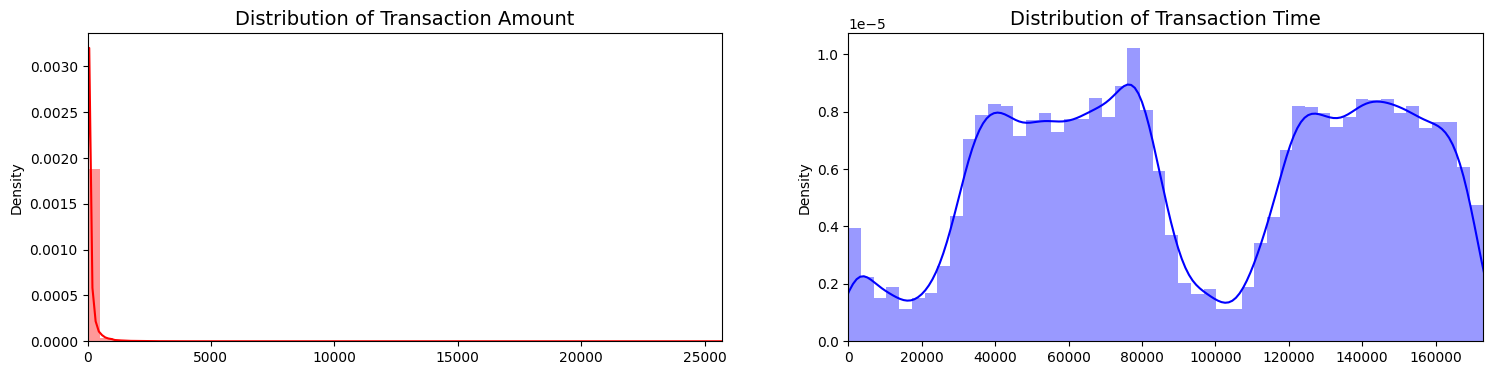

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))


df.drop(['Time','Amount'], axis=1, inplace=True)

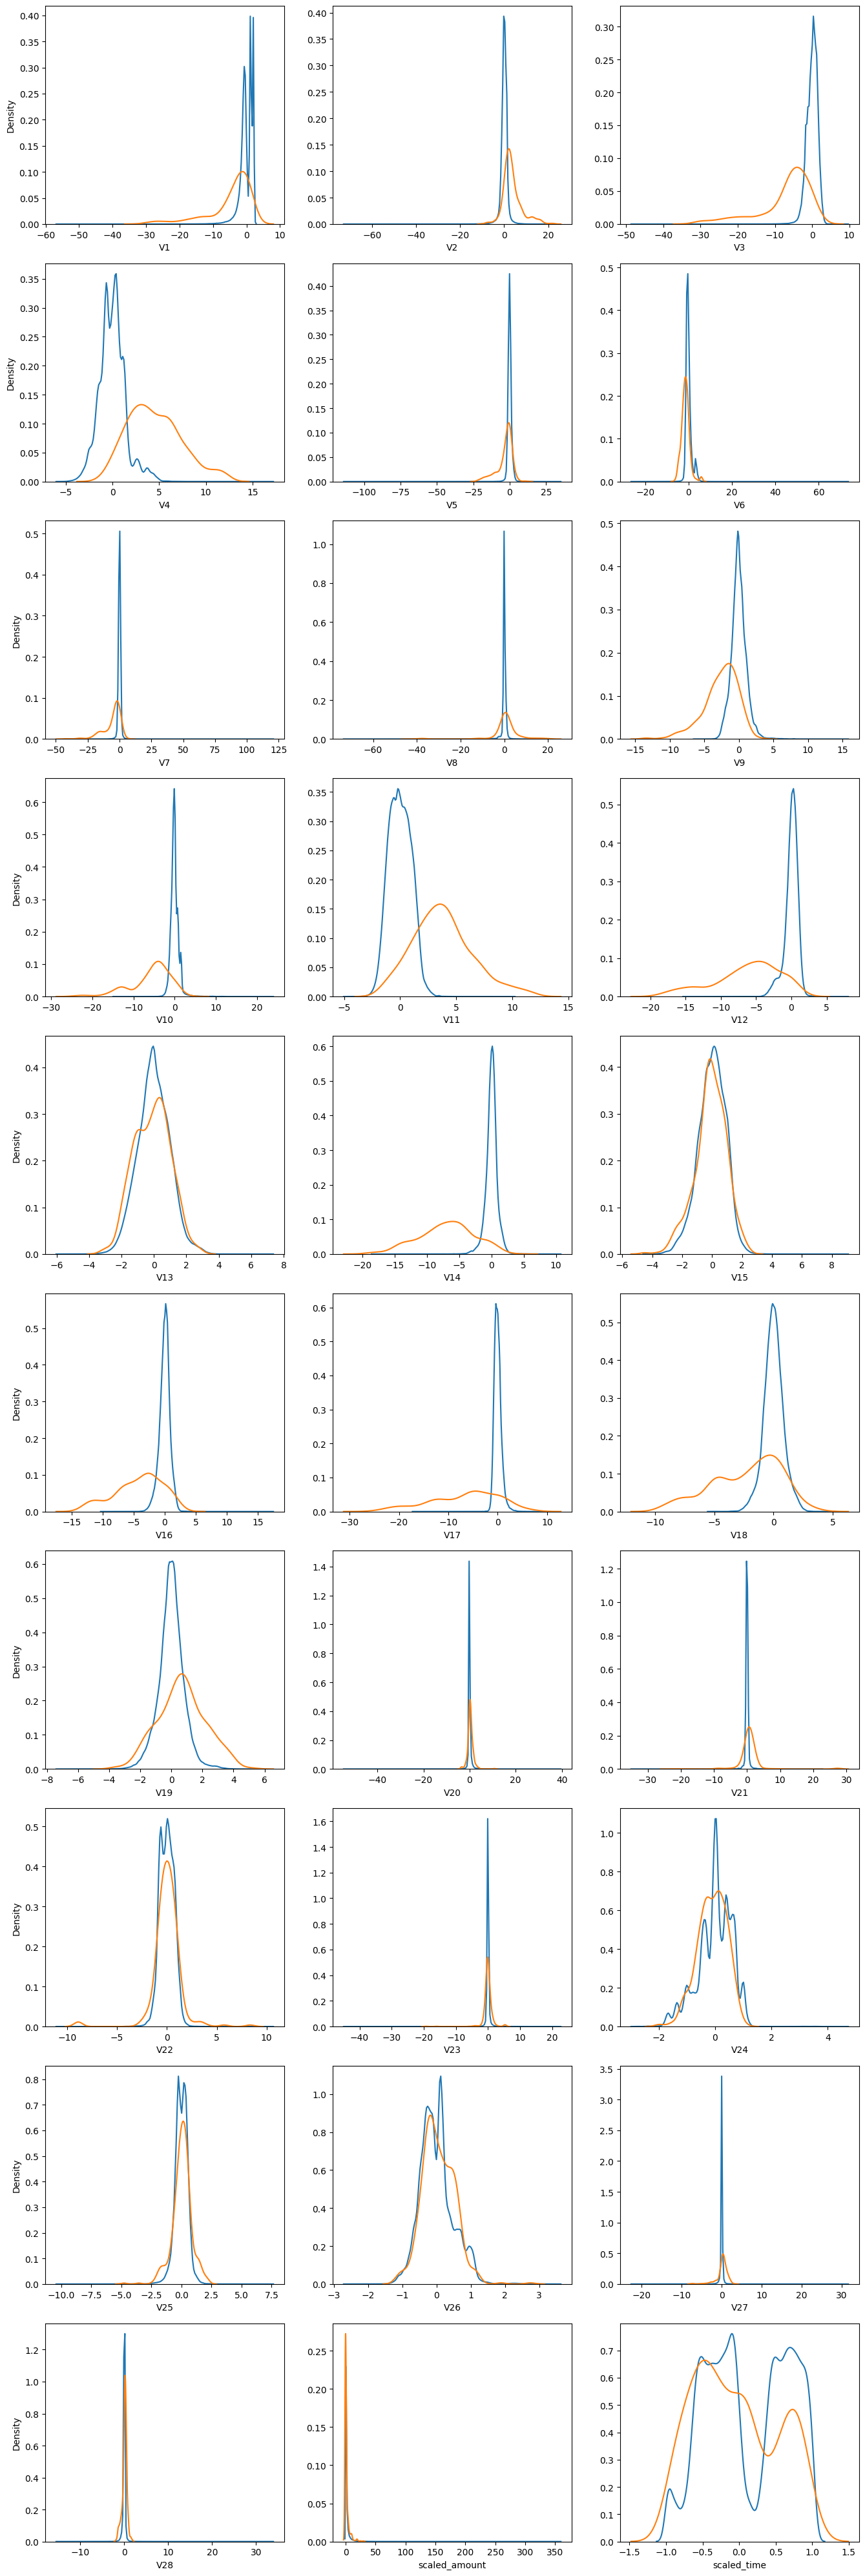

In [ ]:
# Comparison of feature distributions for different target classes
# data_val = pd.concat([X_val, y_val], axis = 1)
data_val_0, data_val_1 = df[df['Class'] == 0], df[df['Class'] == 1]
t = list(df.columns)
t.remove('Class')
cols, ncols = t, 3
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax = ax[i // ncols, i % ncols])
    sns.kdeplot(data_val_1[cols[i]], ax = ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
df.head()

INFO:py4j.clientserver:Closing down clientserver connection
2024-06-18 16:40:00,053 - py4j.clientserver - INFO - Closing down clientserver connection


,V1,V2,V3,V4,V5,...,V27,V28,Class,scaled_time,scaled_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,...,0.133558,-0.021053,0,-0.994983,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,...,-0.008983,0.014724,0,-0.994983,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,...,-0.055353,-0.059752,0,-0.994972,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,...,0.062723,0.061458,0,-0.994972,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,...,0.219422,0.215153,0,-0.994960,0.670579


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
# df_spark = df_spark.select(['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19','Amount','Time','Class'])
# X = df.drop(['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19','Class'], axis=1)
X = df.drop('Class', axis=1)
y = df['Class']

# sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# for train_index, test_index in sss.split(X, y):
#     print("Train:", train_index, "Test:", test_index)
#     original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
#     original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


In [ ]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import linear_model


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()



log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(linear_model.LogisticRegression(), log_reg_params, n_iter=4)

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9749786038754417
precision: 0.05962334322009185
recall: 0.9086335605322947
f1: 0.11186632062203375
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99     56864
       Fraud       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [ ]:
# Let's implement simple classifiers
# from sklearn import linear_model

# classifiers = {
#     "LogisiticRegression": linear_model.LogisticRegression(),
#     "KNearest": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
#     "DecisionTreeClassifier": DecisionTreeClassifier()
# }

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [ ]:
# Define the model
n_inputs = Xsm_train.shape[1]
model = Sequential()
model.add(Dense(30, input_shape=(30, ), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(Xsm_train, ysm_train, epochs=20, batch_size=64, validation_split=0.2, shuffle=True)

Epoch 1/20
5687/5687 [==============================] - 20s 3ms/step - loss: 0.0499 - accuracy: 0.9824 - val_loss: 0.0122 - val_accuracy: 0.9993
Epoch 2/20
5687/5687 [==============================] - 18s 3ms/step - loss: 0.0124 - accuracy: 0.9966 - val_loss: 0.0032 - val_accuracy: 0.9998
Epoch 3/20
5687/5687 [==============================] - 19s 3ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.0035 - val_accuracy: 0.9995
Epoch 4/20
5687/5687 [==============================] - 17s 3ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/20
5687/5687 [==============================] - 17s 3ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/20
5687/5687 [==============================] - 19s 3ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0116 - val_accuracy: 0.9987
Epoch 7/20
5687/5687 [==============================] - 18s 3ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0019 - val_ac

In [ ]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 5s - loss: 0.0600 - accuracy: 0.9782 - val_loss: 0.0196 - val_accuracy: 0.9964 - 5s/epoch - 4ms/step
Epoch 2/20
1214/1214 - 3s - loss: 0.0133 - accuracy: 0.9968 - val_loss: 0.0079 - val_accuracy: 0.9993 - 3s/epoch - 3ms/step
Epoch 3/20
1214/1214 - 3s - loss: 0.0079 - accuracy: 0.9982 - val_loss: 0.0055 - val_accuracy: 0.9996 - 3s/epoch - 3ms/step
Epoch 4/20
1214/1214 - 5s - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.0022 - val_accuracy: 1.0000 - 5s/epoch - 4ms/step
Epoch 5/20
1214/1214 - 5s - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 1.0000 - 5s/epoch - 4ms/step
Epoch 6/20
1214/1214 - 3s - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0017 - val_accuracy: 0.9999 - 3s/epoch - 2ms/step
Epoch 7/20
1214/1214 - 3s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 0.9999 - 3s/epoch - 2ms/step
Epoch 8/20
1214/1214 - 5s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 1.0000 - 5s/epoch - 4ms/step
Epoch 9/

In [ ]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [ ]:
oversample_predictions = model.predict(original_Xtest, batch_size=200, verbose=0)

In [ ]:
test_loss, test_acc = oversample_model.evaluate(original_Xtest, original_ytest)

print('Test accuracy:', test_acc)

1781/1781 [==============================] - 10s 6ms/step - loss: 0.0136 - accuracy: 0.9992
Test accuracy: 0.999210000038147


In [ ]:
oversample_predictions_class = np.argmax(oversample_predictions, axis=-1)

In [ ]:
import os
MD_dir = os.path.join('/content/drive/MyDrive/DS200/Project', "DL_Model")
oversample_model.save(MD_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS200/Project/DL_Model_2/assets
2024-06-18 17:15:27,707 - tensorflow - INFO - Assets written to: /content/drive/MyDrive/DS200/Project/DL_Model_2/assets


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(original_ytest, oversample_predictions_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(original_ytest, oversample_predictions_class)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(original_ytest, oversample_predictions_class)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(original_ytest, oversample_predictions_class)
print('F1 score: %f' % f1)

Accuracy: 0.999210
Precision: 0.752381
Recall: 0.806122
F1 score: 0.778325


In [ ]:
classes_x=np.argmax(oversample_predictions,axis=1)

<Figure size 1600x800 with 0 Axes>

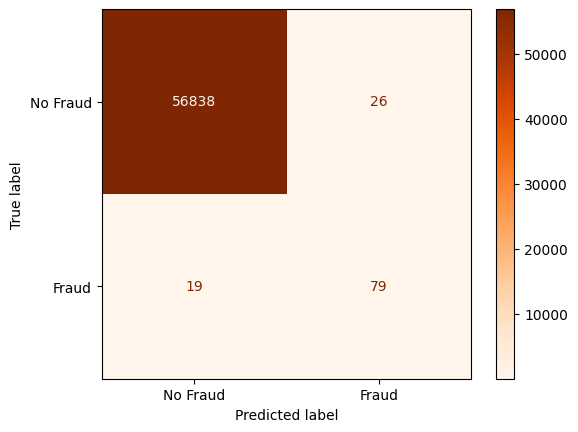

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
oversample_smote = confusion_matrix(original_ytest, classes_x)
# actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

# fig.add_subplot(221)
cfmd = ConfusionMatrixDisplay(oversample_smote, display_labels=labels)
cfmd.plot(cmap=plt.cm.Oranges, values_format='')
# fig.add_subplot(222)
# cfmd2 = ConfusionMatrixDisplay(actual_cm, display_labels=labels)
# cfmd2.plot(cmap=plt.cm.Greens, values_format='')

In [ ]:
import os
MD_dir = os.path.join('/content/drive/MyDrive/DS200/Project', "DL_Model_2")
model.save(MD_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS200/Project/DL_Model_2/assets
2024-06-18 18:00:42,085 - tensorflow - INFO - Assets written to: /content/drive/MyDrive/DS200/Project/DL_Model_2/assets


In [ ]:
import os
MD_dir = os.path.join('/content/drive/MyDrive/DS200/Project', "DL_Model_3.keras")
model.save(MD_dir)

In [ ]:
import os
MD_dir = os.path.join('/content/drive/MyDrive/DS200/Project', "DL_Model.h5")
oversample_model.save(MD_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
MD_dir

'/content/drive/MyDrive/DS200/Project/DL_Model.h5'

In [ ]:
new_model = tf.keras.models.load_model(MD_dir)
new_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 30)                930       
                                                                 
 dense_45 (Dense)            (None, 32)                992       
                                                                 
 dense_46 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
new_model = tf.keras.models.load_model(MD_dir)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# PySpark

In [10]:
from pyspark.sql.functions import when, col, regexp_replace, array
from sklearn import neighbors
import random
from pyspark.sql import Row
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StandardScaler, RobustScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, FloatType, Union, Dict
from pyspark.ml.classification import LogisticRegression as LogisticRegressionSpark
from pyspark.sql.functions import explode, array, lit, col, udf
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.types import FloatType, ArrayType
from pyspark.ml.classification import RandomForestClassifier as RandomForestClassifierSpark

In [11]:
df_spark = spark.read.format("csv").load("creditcard.csv",header = 'True',inferSchema='True')

In [12]:
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

In [13]:
value_0 = train_data.filter(train_data.Class == 0)
value_1 = train_data.filter(train_data.Class == 1)
value_0.count()/train_data.count(), value_1.count()/train_data.count()

(0.9982135803011017, 0.0017864196988983015)

In [14]:
value_0 = test_data.filter(test_data.Class == 0)
value_1 = test_data.filter(test_data.Class == 1)
value_0.count()/test_data.count(), value_1.count()/test_data.count()

(0.9985081699633185, 0.001491830036681468)

In [15]:
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

# Không chọn tham số maxDepth vì thời gian chạy lâu và làm giảm performance.(MaxDepth = 5)

# Undersamping

In [ ]:
cols_to_scale = ['Time','Amount']

scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures")
assembler = VectorAssembler().setInputCols(cols_to_scale).setOutputCol("features")

df_spark_transformed = assembler.transform(train_data)
scaler_model = scaler.fit(df_spark_transformed.select("features"))
df_spark_scaled = scaler_model.transform(df_spark_transformed)

cols = ('Time','features','Amount')

df_train_spark_scaled = df_spark_scaled.drop(*cols)

In [ ]:
df_test_spark_transformed = assembler.transform(test_data)
df_test_spark_scaled = scaler_model.transform(df_test_spark_transformed)

cols = ('Time','features','Amount')

df_test_spark_scaled = df_test_spark_scaled.drop(*cols)

In [ ]:
df_class_0 = df_train_spark_scaled.filter(df_train_spark_scaled["Class"] == 0)
df_class_1 = df_train_spark_scaled.filter(df_train_spark_scaled["Class"] == 1)

In [ ]:
sampled_majority_df = df_class_0.sample(False, 1/20)
combined_df = sampled_majority_df.unionAll(df_class_1)

In [ ]:
train_data_new = combined_df

In [ ]:
test_data_new = df_test_spark_scaled

In [ ]:
test_data_new = vectorizerFunction(test_data_new, 'Class')
train_data_new = vectorizerFunction(train_data_new, 'Class')

## LogisticRegressionSpark

In [ ]:
lgr = LogisticRegressionSpark(labelCol='label',featuresCol='features')
model_lgr = lgr.fit(train_data_new)
model_lgr.transform(train_data_new)

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predictions = model_lgr.transform(test_data_new)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9984204152552785


In [ ]:
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|label|  0.0|1.0|
+-----+-----+---+
|    1|   16| 69|
|    0|56818| 74|
+-----+-----+---+



In [ ]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.48      0.81      0.61        85

    accuracy                           1.00     56977
   macro avg       0.74      0.91      0.80     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.65


In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9052319978824688


## RandomForestClassifierSpark

### Chọn tham số

In [ ]:
rf = RandomForestClassifierSpark(labelCol='label',featuresCol='features')
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,50,100,150,180,200]).build())

# Set up the CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy'),
                          numFolds=5)

In [ ]:
cvModel = crossval.fit(train_data_new)

INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
2024-06-27 13:52:26,265 - py4j.clientserver - INFO - Closing down clientserver connection
2024-06-27 13:52:26,266 - py4j.clientserver - INFO - Closing down clientserver connection


In [ ]:
# Get the best model
bestModel = cvModel.bestModel
# Evaluate the best model on the test data
bestModel.transform(train_data_new)
predictions = bestModel.transform(test_data_new)

y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.65      0.80      0.72        85

    accuracy                           1.00     56977
   macro avg       0.82      0.90      0.86     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|label|  0.0|1.0|
+-----+-----+---+
|    1|   17| 68|
|    0|56855| 37|
+-----+-----+---+



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.72


In [ ]:
bestModel.getMaxDepth()

5

In [ ]:
bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_e81d72887831, numTrees=100, numClasses=2, numFeatures=30

### Không chọn tham số

In [ ]:
rf = RandomForestClassifierSpark(labelCol='label',featuresCol='features')
model_rf = rf.fit(train_data_new)
model_rf.transform(train_data_new)

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predictions = model_rf.transform(test_data_new)

In [ ]:
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|label|  0.0|1.0|
+-----+-----+---+
|    1|   16| 69|
|    0|56864| 28|
+-----+-----+---+



In [ ]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.71      0.81      0.76        85

    accuracy                           1.00     56977
   macro avg       0.86      0.91      0.88     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.76


In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9056362726486924


# Oversampling by duplicating minority class

In [ ]:
cols_to_scale = ['Time','Amount']

scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures")
assembler = VectorAssembler().setInputCols(cols_to_scale).setOutputCol("features")

df_spark_transformed = assembler.transform(train_data)
scaler_model = scaler.fit(df_spark_transformed.select("features"))
df_spark_scaled = scaler_model.transform(df_spark_transformed)

cols = ('Time','features','Amount')

df_train_spark_scaled = df_spark_scaled.drop(*cols)

In [ ]:
df_test_spark_transformed = assembler.transform(test_data)
df_test_spark_scaled = scaler_model.transform(df_test_spark_transformed)

cols = ('Time','features','Amount')

df_test_spark_scaled = df_test_spark_scaled.drop(*cols)

In [ ]:
df_class_0 = df_train_spark_scaled.filter(df_train_spark_scaled["Class"] == 0)
df_class_1 = df_train_spark_scaled.filter(df_train_spark_scaled["Class"] == 1)

In [ ]:
a = range(100)
# duplicate the minority rows
oversampled_df = df_class_1.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
combined_df = df_class_0.unionAll(oversampled_df)

In [ ]:
train_data_new = combined_df

In [ ]:
test_data_new = df_test_spark_scaled

In [ ]:
test_data_new = vectorizerFunction(test_data_new, 'Class')
train_data_new = vectorizerFunction(train_data_new, 'Class')

In [ ]:
value_0 = train_data_new.filter(train_data_new.label == 0)
value_1 = train_data_new.filter(train_data_new.label == 1)
value_0.count()/train_data_new.count(), value_1.count()/train_data_new.count()

(0.8482039959272424, 0.15179600407275765)

## LogisticRegressionSpark

In [ ]:
lgr = LogisticRegressionSpark(labelCol='label',featuresCol='features')
model_lgr = lgr.fit(train_data_new)
model_lgr.transform(train_data_new)

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predictions = model_lgr.transform(test_data_new)

In [ ]:
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|label|  0.0|1.0|
+-----+-----+---+
|    1|   15| 70|
|    0|56690|202|
+-----+-----+---+



In [ ]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.26      0.82      0.39        85

    accuracy                           1.00     56977
   macro avg       0.63      0.91      0.70     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.54


In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9099894123437183


## RandomForestClassifierSpark

### Chọn tham số

In [ ]:
rf = RandomForestClassifierSpark(labelCol='label',featuresCol='features')
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [5,8,10,50,100]).build())

# Set up the CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy'),
                          numFolds=5)

In [ ]:
cvModel = crossval.fit(train_data_new)

INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
2024-06-27 15:55:28,317 - py4j.clientserver - INFO - Closing down clientserver connection
2024-06-27 15:55:28,318 - py4j.clientserver - INFO - Closing down clientserver connection


In [ ]:
# Get the best model
bestModel = cvModel.bestModel
# Evaluate the best model on the test data
bestModel.transform(train_data_new)
predictions = bestModel.transform(test_data_new)

y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.65      0.80      0.72        85

    accuracy                           1.00     56977
   macro avg       0.82      0.90      0.86     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|label|  0.0|1.0|
+-----+-----+---+
|    1|   17| 68|
|    0|56855| 37|
+-----+-----+---+



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.72


In [ ]:
bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_341336dadf99, numTrees=10, numClasses=2, numFeatures=30

### Không chọn tham số

In [ ]:
rf = RandomForestClassifierSpark(labelCol='label',featuresCol='features')
model_rf = rf.fit(train_data_new)
model_rf.transform(train_data_new)

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predictions = model_rf.transform(test_data_new)

In [ ]:
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|label|  0.0|1.0|
+-----+-----+---+
|    1|   16| 69|
|    0|56855| 37|
+-----+-----+---+



In [ ]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.65      0.81      0.72        85

    accuracy                           1.00     56977
   macro avg       0.83      0.91      0.86     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.73


In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9055571754118227


# DL (Kết quả tốt nhất)

## Chạy model và lưu kết quả

In [ ]:
# ! pip install tensorflow tensorflowonspark

In [ ]:
# df_spark = spark.read.format("csv").load("creditcard.csv",header = 'True',inferSchema='True')

In [ ]:
# train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# from pyspark.ml.feature import MinMaxScaler, StandardScaler, RobustScaler
# cols_to_scale = ['Time','Amount']

# scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures")
# assembler = VectorAssembler().setInputCols(cols_to_scale).setOutputCol("features")

# df_spark_transformed = assembler.transform(train_data)
# scaler_model = scaler.fit(df_spark_transformed.select("features"))
# df_spark_scaled = scaler_model.transform(df_spark_transformed)

# cols = ('Time','features','Amount')

# df_train_spark_scaled = df_spark_scaled.drop(*cols)

In [ ]:
# df_test_spark_transformed = assembler.transform(test_data)
# df_test_spark_scaled = scaler_model.transform(df_test_spark_transformed)

# cols = ('Time','features','Amount')

# df_test_spark_scaled = df_test_spark_scaled.drop(*cols)

In [ ]:
scaler = RobustScaler(inputCol="features_T_A", outputCol="scaledFeatures")
assembler = VectorAssembler().setInputCols(['Time','Amount']).setOutputCol("features_T_A")
assembler_2 = VectorAssembler().setInputCols(['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28',"scaledFeatures"]).setOutputCol("features")
pipeline = Pipeline( stages = [assembler,scaler,assembler_2])

In [ ]:
pipe = pipeline.fit(train_data)

In [ ]:
df_spark_scaled = pipe.transform(train_data)
df_test_spark_scaled = pipe.transform(test_data)

# cols = ('Time','features','Amount')
# df_train_spark_scaled = df_spark_scaled.drop(*cols)
# df_test_spark_scaled = df_test_spark_scaled.drop(*cols)

In [ ]:
import os
MD_dir = os.path.join('/content/drive/MyDrive/DS200/Project', "DL_Model.h5")

In [ ]:
def Model_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(MD_dir)
    def predict(inputs: np.str_) -> np.ndarray:
        return model.predict(inputs)

    return predict

In [ ]:
# df_spark_scaled.select("features").first()[0].toArray().tolist()

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType, FloatType
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

In [ ]:
from pyspark.sql.functions import explode
test_data_new_array = df_test_spark_scaled.withColumn('features_array', to_array('features'))

In [ ]:
# input_shape = len(test_data_new_array.collect()[0]['features_array'])

In [ ]:
RNN_sent = predict_batch_udf(Model_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=16,
                          input_tensor_shapes=[[30, ]])

In [ ]:
# type(RNN_preds.select("preds").first()[0])

In [ ]:
# Apply the UDF to the combined array column
RNN_preds = test_data_new_array.withColumn("preds", RNN_sent("features_array")).toPandas()

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # Import the missing class

# Assuming your model outputs probabilities and you want the class with highest probability
def get_predicted_class(preds):
  return float(np.argmax(preds))  # Convert to float for DoubleType compatibility

get_predicted_class_udf = udf(get_predicted_class, DoubleType())
RNN_preds_spark = spark.createDataFrame(RNN_preds)
# Apply the UDF to extract the predicted class from the array
RNN_preds_spark = RNN_preds_spark.withColumn("preds", get_predicted_class_udf("preds"))

# Now evaluate the accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='preds', metricName='accuracy')
accuracy = evaluator.evaluate(RNN_preds_spark)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9995612264597996


In [ ]:
y_pred = RNN_preds_spark.select('preds').collect()
y_pred_array = [x[0] for x in y_pred]
y = RNN_preds_spark.select('Class').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.86      0.85      0.85        85

    accuracy                           1.00     56977
   macro avg       0.93      0.92      0.93     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.85


In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9234239487822128


In [ ]:
# pipe.write().overwrite().save("Pipe")

In [ ]:
confusion_matrix = RNN_preds_spark.groupBy("Class").pivot("preds").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|Class|  0.0|1.0|
+-----+-----+---+
|    0|56880| 12|
|    1|   13| 72|
+-----+-----+---+



* Lưu scaler và model thành 2 file riêng.

## Load và chạy model và scaler

In [ ]:
df_spark = spark.read.format("csv").load("creditcard.csv",header = 'True',inferSchema='True')

In [ ]:
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml import PipelineModel
pipe = PipelineModel.read().load("Pipe")

In [ ]:
df_test_spark_scaled = pipe.transform(test_data)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType, FloatType
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

In [ ]:
from pyspark.sql.functions import explode
test_data_new_array = df_test_spark_scaled.withColumn('features_array', to_array('features'))

In [ ]:
import os
MD_dir = os.path.join('/content/drive/MyDrive/DS200/Project', "DL_Model_2")

In [ ]:
def Model_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(MD_dir)
    def predict(inputs: np.str_) -> np.ndarray:
        return model.predict(inputs)

    return predict

In [ ]:
RNN_sent = predict_batch_udf(Model_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=16,
                          input_tensor_shapes=[[30, ]])

In [ ]:
# Apply the UDF to the combined array column
RNN_preds = test_data_new_array.withColumn("preds", RNN_sent("features_array")).toPandas()

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # Import the missing class

# Assuming your model outputs probabilities and you want the class with highest probability
def get_predicted_class(preds):
  return float(np.argmax(preds))  # Convert to float for DoubleType compatibility

get_predicted_class_udf = udf(get_predicted_class, DoubleType())
RNN_preds_spark = spark.createDataFrame(RNN_preds)
# Apply the UDF to extract the predicted class from the array
RNN_preds_spark = RNN_preds_spark.withColumn("preds", get_predicted_class_udf("preds"))

In [ ]:
# Now evaluate the accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='preds', metricName='accuracy')
accuracy = evaluator.evaluate(RNN_preds_spark)
print(f'Accuracy: {accuracy}')

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='preds', metricName='accuracy')
predictions_label_fraud = RNN_preds_spark.filter(RNN_preds_spark.preds == 1)
print(f'Accuracy: {evaluator.evaluate(predictions_label_fraud)}')

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='preds', metricName='accuracy')
predictions_label_fraud = RNN_preds_spark.filter(RNN_preds_spark.Class == 1)
print(f'Accuracy: {evaluator.evaluate(predictions_label_fraud)}')

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='preds', metricName='accuracy')
predictions_label_fraud = RNN_preds_spark.filter(RNN_preds_spark.Class == 0)
print(f'Accuracy: {evaluator.evaluate(predictions_label_fraud)}')

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='preds', metricName='accuracy')
predictions_label_fraud = RNN_preds_spark.filter(RNN_preds_spark.preds == 0)
print(f'Accuracy: {evaluator.evaluate(predictions_label_fraud)}')

In [ ]:
precision_evaluator = MulticlassClassificationEvaluator(predictionCol="preds", labelCol="Class", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(predictionCol="preds", labelCol="Class", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(predictionCol="preds", labelCol="Class", metricName="f1")

precision = precision_evaluator.evaluate(RNN_preds_spark)
recall = recall_evaluator.evaluate(RNN_preds_spark)
f1_score = f1_evaluator.evaluate(RNN_preds_spark)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

In [ ]:
RNN_preds_spark.filter(RNN_preds_spark.Class == 1).count()

In [ ]:
confusion_matrix = RNN_preds_spark.groupBy("Class").pivot("preds").count().fillna(0)
confusion_matrix.show()

In [ ]:
# from pyspark.mllib.evaluation import MulticlassMetrics
# matrix = RNN_preds_spark.select('Class','preds')
# metrics = MulticlassMetrics(matrix.rdd.map(tuple))

# print(metrics.confusionMatrix().toArray())

# OverSampling using SMOTE library

In [ ]:
# df_spark = df_spark.select(['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19','Amount','Time','Class'])

In [16]:
cols_to_scale = ['Time','Amount']

scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures")
assembler = VectorAssembler().setInputCols(cols_to_scale).setOutputCol("features")

df_spark_transformed = assembler.transform(train_data)
scaler_model = scaler.fit(df_spark_transformed.select("features"))
df_spark_scaled = scaler_model.transform(df_spark_transformed)

cols = ('Time','features','Amount')

df_train_spark_scaled = df_spark_scaled.drop(*cols)

In [17]:
df_test_spark_transformed = assembler.transform(test_data)
df_test_spark_scaled = scaler_model.transform(df_test_spark_transformed)

cols = ('Time','features','Amount')

df_test_spark_scaled = df_test_spark_scaled.drop(*cols)

In [18]:
def vector_to_array(vector):
    return vector.toArray().tolist()

vector_to_array_udf = udf(vector_to_array, ArrayType(FloatType()))

# Apply the UDF to create a new column with array type
df_with_array = df_train_spark_scaled.withColumn("scaledFeatures_array", vector_to_array_udf(df_train_spark_scaled["scaledFeatures"]))
df_test_with_array = df_test_spark_scaled.withColumn("scaledFeatures_array", vector_to_array_udf(df_test_spark_scaled["scaledFeatures"]))

In [19]:
# Define the number of elements in the DenseVector
num_elements = 2  # Adjust based on your vector size

# Create separate columns for each element in the array
for i in range(num_elements):
    df_with_array = df_with_array.withColumn(f"feature_{i+1}", col("scaledFeatures_array")[i])
    df_test_with_array = df_test_with_array.withColumn(f"feature_{i+1}", col("scaledFeatures_array")[i])

# Drop the temporary array column if not needed
df_final_train = df_with_array.drop("scaledFeatures_array")
df_final_test = df_test_with_array.drop("scaledFeatures_array")

In [20]:
# Convert to Pandas DataFrame
train_pd_df = df_final_train.select('V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28',"feature_1","feature_2","class").toPandas()

from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(train_pd_df[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28',"feature_1","feature_2"]], train_pd_df['class'])

# Convert back to PySpark DataFrame
resampled_df = spark.createDataFrame(pd.concat([X_resampled, y_resampled], axis=1))

In [21]:
assembler = VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28',"feature_1","feature_2"],outputCol="features")
train_data_new = assembler.transform(resampled_df)
test_data_new = assembler.transform(df_final_test)

In [ ]:
value_0 = train_data_new.filter(train_data_new["class"] == 0)
value_1 = train_data_new.filter(train_data_new["class"] == 1)
value_0.count()/train_data_new.count(), value_1.count()/train_data_new.count()

(0.5, 0.5)

In [ ]:
train_data_new.count()

454846

In [ ]:
value_0.count()

227423

## SVC

In [ ]:
from pyspark.ml.classification import LinearSVC

# Initialize the model
lsvc = LinearSVC(labelCol='class',featuresCol='features')

# Train the model
lsvc_model = lsvc.fit(train_data_new)
predictions = lsvc_model.transform(test_data_new)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.980729066114397


In [ ]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('Class').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56892
           1       0.07      0.89      0.12        85

    accuracy                           0.98     56977
   macro avg       0.53      0.94      0.56     56977
weighted avg       1.00      0.98      0.99     56977



## LogisticRegression

In [22]:
lgr = LogisticRegressionSpark(labelCol='class',featuresCol='features')
model_lgr = lgr.fit(train_data_new)
model_lgr.transform(train_data_new)

DataFrame[V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, feature_1: double, feature_2: double, class: bigint, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [23]:
predictions = model_lgr.transform(test_data_new)

In [24]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9805886585815329


In [25]:
confusion_matrix = predictions.groupBy("Class").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+----+
|Class|  0.0| 1.0|
+-----+-----+----+
|    1|    8|  77|
|    0|55794|1098|
+-----+-----+----+



In [26]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('Class').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56892
           1       0.07      0.91      0.12        85

    accuracy                           0.98     56977
   macro avg       0.53      0.94      0.56     56977
weighted avg       1.00      0.98      0.99     56977



In [27]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.49


In [28]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9432913135724654


## RandomForestClassifier

### Chọn tham số

In [ ]:
rf = RandomForestClassifierSpark(labelCol='class',featuresCol='features')
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,20,50,100,180]).build())

# Set up the CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='class', metricName='accuracy'),
                          numFolds=5)

In [ ]:
cvModel = crossval.fit(train_data_new)

INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
2024-06-28 05:34:07,420 - py4j.clientserver - INFO - Closing down clientserver connection
2024-06-28 05:34:07,423 - py4j.clientserver - INFO - Closing down clientserver connection


In [ ]:
bestModel = cvModel.bestModel

In [ ]:
bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_261ab09084eb, numTrees=10, numClasses=2, numFeatures=30

In [ ]:
bestModel.save("SMOTE_Li_BestModel_RandomFR")

In [ ]:
# Evaluate the best model on the test data
bestModel.transform(train_data_new)
predictions = bestModel.transform(test_data_new)

y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('class').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.21      0.84      0.33        85

    accuracy                           0.99     56977
   macro avg       0.60      0.92      0.66     56977
weighted avg       1.00      0.99      1.00     56977



In [ ]:
confusion_matrix = predictions.groupBy("class").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|class|  0.0|1.0|
+-----+-----+---+
|    1|   14| 71|
|    0|56620|272|
+-----+-----+---+



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.52


### Không chọn tham số

In [29]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol='class',featuresCol='features')
model_rf = rf.fit(train_data_new)
model_rf.transform(train_data_new)

DataFrame[V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, feature_1: double, feature_2: double, class: bigint, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [30]:
predictions = model_rf.transform(test_data_new)

In [31]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9970514418098531


In [32]:
confusion_matrix = predictions.groupBy("Class").pivot("prediction").count().fillna(0)
confusion_matrix.show()

+-----+-----+---+
|Class|  0.0|1.0|
+-----+-----+---+
|    1|   13| 72|
|    0|56737|155|
+-----+-----+---+



In [33]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('Class').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.32      0.85      0.46        85

    accuracy                           1.00     56977
   macro avg       0.66      0.92      0.73     56977
weighted avg       1.00      1.00      1.00     56977



In [34]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.58


In [35]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.9221671815741695


# XGBoost

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
from xgboost.spark import SparkXGBClassifier

spark_reg_estimator = SparkXGBClassifier(
  features_col="features",
  label_col="Class",
  num_workers=1,
)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = (ParamGridBuilder()
            .addGrid(spark_reg_estimator.n_estimators, [int(v) for v in np.arange(50, 200, 50)])
            .addGrid(spark_reg_estimator.max_depth,[4, 6, 8, 10])
            .build())

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")

crossval_xgb = CrossValidator(estimator=spark_reg_estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# scaler = RobustScaler(inputCol="features_T_A", outputCol="scaledFeatures")
scaler_Standard = StandardScaler(inputCol="features_T_A", outputCol="scaledFeatures")
assembler = VectorAssembler().setInputCols(['Time','Amount']).setOutputCol("features_T_A")
assembler_2 = VectorAssembler().setInputCols(['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28',"scaledFeatures"]).setOutputCol("features")
# pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pipeline = Pipeline( stages = [assembler,scaler_Standard,assembler_2,spark_reg_estimator])

In [ ]:
model = pipeline.fit(train_data)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-07-02 03:02:36,526 - XGBoost-PySpark - INFO - Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
2024-07-02 03:02:59,674 - XGBoost-PySpark - INFO - Finished xgboost training!


In [ ]:
model.stages[-1].params

In [ ]:
result = model.transform(test_data)

In [ ]:
y_pred = result.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]

In [ ]:
y = test_data.select('Class').collect()
y_array = [x[0] for x in y]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.94      0.78      0.85        85

    accuracy                           1.00     56977
   macro avg       0.97      0.89      0.93     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.8882001397901492


# SVC

In [ ]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.classification import LinearSVC, LogisticRegression
lsvc_estimator = LinearSVC(labelCol='Class',featuresCol='features')
lgr_estimator = LogisticRegressionSpark(labelCol='Class',featuresCol='features')

In [ ]:

spark_reg_estimator = SparkXGBClassifier(
  features_col="features",
  label_col="Class",
  num_workers=1,
)

In [ ]:
# scaler = RobustScaler(inputCol="features_T_A", outputCol="scaledFeatures")
scaler_Standard = StandardScaler(inputCol="features_T_A", outputCol="scaledFeatures")
assembler = VectorAssembler().setInputCols(['Time','Amount']).setOutputCol("features_T_A")
assembler_2 = VectorAssembler().setInputCols(['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28',"scaledFeatures"]).setOutputCol("features")
# pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pipeline = Pipeline( stages = [assembler,scaler_Standard,assembler_2,lsvc_estimator])

In [ ]:
model = pipeline.fit(train_data)

In [ ]:
result = model.transform(test_data)

SVC

In [ ]:
y_pred = result.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = test_data.select('Class').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.79      0.74      0.76        85

    accuracy                           1.00     56977
   macro avg       0.89      0.87      0.88     56977
weighted avg       1.00      1.00      1.00     56977



In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_array, y_pred_array)

# Calculate the area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

Area Under the Precision-Recall Curve (AUPRC): 0.76


In [ ]:
auc = roc_auc_score(y_array, y_pred_array)
print("AUC-ROC:", auc)

AUC-ROC: 0.8704388294022524
